# NTSB Aviation Accident Database Analysis

The following analysis looks at the NTSB Accident Database (linked here) and looks at accidents as a function of various database features, with the intention of identifying airplanes with a strong safety record that would be good to purchase for leasing purposes.

## Data Cleaning

This particular analysis will look at the following features of the accident report.  

To begin, we will readin the data and clean up each of these features`

### Import the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Data/Aviation_Data.csv")

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_11666/2459307861.py:1: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/Aviation_Data.csv")


### Date of Accident

Convert the string representation of Event.Date to a Pandas date-time object and store in same column

In [2]:
years=pd.to_datetime(df["Event.Date"], format="%Y-%m-%d").dt.year
#np.histogram(years)
count, years = np.histogram(years[years.isna()==False], bins=range(1982,2024,1))

pd.DataFrame(count,index=years[0:41]).plot.bar()

NameError: name 'pd' is not defined

### Normalizing Make and Model

This analysis will concentrate on the set of airplanes Models that are currently in production.  The dataframe models_of_interest holds data about these models.  
The database Make and Model values are updated to use consistent naming.

In [ ]:
count

array([3593, 3556, 3457, 3096, 2880, 2828, 2730, 2544, 2518, 2462, 2355,
       2313, 2257, 2309, 2187, 2148, 2226, 2209, 2220, 2063, 2020, 2085,
       1952, 2031, 1851, 2016, 1893, 1783, 1786, 1850, 1835, 1561, 1535,
       1582, 1664, 1638, 1681, 1624, 1392, 1545, 1607])

In [ ]:
df[df["Air.carrier"]=="UNITED AIRLINES"].groupby(["Air.carrier","Purpose.of.flight"]).count()

,,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,FAR.Description,Schedule,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
Air.carrier,Purpose.of.flight,,,,,,,,,,,,,,,,,,,,,


In [ ]:
df["Air.carrier"].value_counts().to_csv("carriers.csv")

In [ ]:
def normalize(name, normalized_names):
    for x in normalized_names:
        if x.lower() in str(name).lower():
            return x
    return name

#manufacturers = {"Boeing":"", "Airbus":"Airbus", "Comac":"Comac", "Embraer":"Embraer",
#"Havilland":"de Havilland", "Britten":"Britten-Norman", "Evektor":"Evektor", "Cessna":"Cessna", "Texas Aircraft":"Texas Aircraft", "Piper":"Piper",
#"Cubcrafters":"Cubcrafters","Beechcraft":"Beechcraft","Diamond":"Diamond",
#"Cirrus":"Cirrus","Bombardier":"Bombardier"}

models_of_interest = pd.DataFrame([["Boeing","737",11762], ["Boeing","767",1311], ["Airbus","A320",11471], ["Airbus","A340", 380],
["Boeing",'777',1729], ["Airbus","A319",1501], ["Airbus",'A330',1601], ["Airbus","A321",3145],
["Boeing","787",1129], ["Airbus","A350",602], ["Airbus",'A220',335]],columns=["Make","Model","Produced"])

df["Make"]=df["Make"].map(lambda x:str(x))
df.loc["Model"]=df["Model"].map(lambda x:str(x))

df["Make"] = df["Make"].map(lambda x:normalize(x,models_of_interest["Make"].unique()))
df["Model"] = df["Model"].map(lambda x:normalize(x,models_of_interest["Model"].unique()))

df.to_csv("test.csv")

models_of_interest["Make"].unique()


array(['Boeing', 'Airbus'], dtype=object)

Airplane Makes and Models that are not of interest are removed from the data set.

In [ ]:
filter = df["Make"].map(lambda x:x in models_of_interest["Make"].unique())
df = df[filter]

filter = df["Model"].map(lambda x:x in models_of_interest["Model"].unique())
df = df[filter]

#df[df["Make"]=="Airbus"]


for col in ["Total.Serious.Injuries","Total.Fatal.Injuries"]:
    df[col]=df[col].map(lambda x:0 if np.isnan(x) else int(x))

incidents = df.groupby(["Make","Model"]).count()["Total.Serious.Injuries"]
incidents_injuries=df[df["Total.Serious.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Serious.Injuries"]

incidents_fatal=df[df["Total.Fatal.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Fatal.Injuries"]
injury_total=df.groupby(["Make","Model"]).sum()[["Total.Serious.Injuries","Total.Fatal.Injuries"]]


## Data Analysis
An analysis then looks at the number of incidents vs. airplane Make and Model.

In [ ]:
modelCompare=pd.concat([incidents,incidents_injuries,incidents_fatal,injury_total],axis=1)
modelCompare.columns=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities"]

for col in modelCompare.columns:
    modelCompare[col]=modelCompare[col].map(lambda x: 0 if np.isnan(x) else int(x))


produced = models_of_interest.set_index(["Make","Model"])
modelCompare = modelCompare.sort_values(["Make","Model"])
modelCompare = pd.concat([modelCompare,produced], axis=1)


In [ ]:
modelCompare["IncidentsRatio"]=modelCompare["Incidents-Any"]/modelCompare["Produced"]
modelCompare["IncidentsFatalitiesRatio"]=modelCompare["Incidents-Fatalities"]/modelCompare["Produced"]
modelCompare["IncidentsInjuriesRatio"]=modelCompare["Incidents-Injuries"]/modelCompare["Produced"]

In [ ]:
modelCompare[["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities","Produced"]]


Incidents-Any  Incidents-Injuries  Incidents-Fatalities  \
Make   Model                                                            
Airbus A220               5                   0                     0   
       A319              52                  15                     0   
       A320             152                  17                    10   
       A321              36                   2                     2   
       A330              63                   6                     2   
       A340               5                   1                     0   
       A350               2                   0                     1   
Boeing 737             1040                 148                    60   
       767              213                  48                     6   
       777              165                  26                     4   
       787               42                   4                     0   

              Total Injuries  Total Fatalities  Produced  
Make   Model                                              
Airbus A220                0                 0       335  
       A319               62                 0      1501  
       A320               96              1027     11471  
       A321                9               381      3145  
       A330               36               331      1601  
       A340                2                 0       380  
       A350                0                 1       602  
Boeing 737              1038              3897     11762  
       767               251               640      1311  
       777               221               538      1729  
       787                12                 0      1129

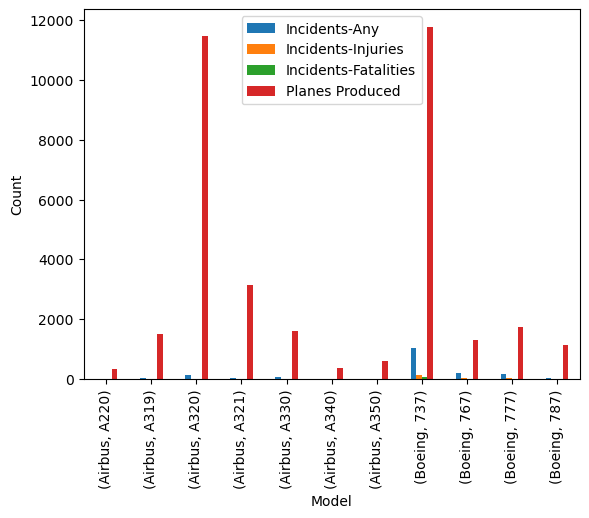

In [ ]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Produced"], ax=ax)
ax.legend(["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Planes Produced"])
ax.set_xlabel("Model")
ax.set_ylabel("Count")
fig.savefig("fig1.png")

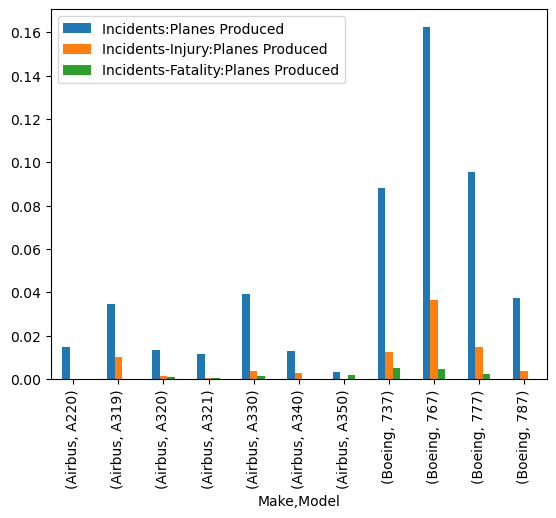

In [ ]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["IncidentsRatio","IncidentsInjuriesRatio","IncidentsFatalitiesRatio"], ax=ax)
ax.legend(["Incidents:Planes Produced","Incidents-Injury:Planes Produced","Incidents-Fatality:Planes Produced"])
fig.savefig("fig2.png")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1775 entries, 84 to 90338
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                1775 non-null   object 
 1   Investigation.Type      1775 non-null   object 
 2   Accident.Number         1775 non-null   object 
 3   Event.Date              1775 non-null   object 
 4   Location                1769 non-null   object 
 5   Country                 1774 non-null   object 
 6   Latitude                530 non-null    object 
 7   Longitude               530 non-null    object 
 8   Airport.Code            635 non-null    object 
 9   Airport.Name            683 non-null    object 
 10  Injury.Severity         1280 non-null   object 
 11  Aircraft.damage         803 non-null    object 
 12  Aircraft.Category       1166 non-null   object 
 13  Registration.Number     1612 non-null   object 
 14  Make                    1775 non-null   obj

In [ ]:
df["Number.of.Engines"].value_counts()

Number.of.Engines
2.0    924
0.0      7
4.0      3
1.0      2
Name: count, dtype: int64